In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Dec 12 23:57:01 2017
@author: srajanku
"""

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
# Read in our vehicles and non-vehicles

/home/shubhra-rajan/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
cars = []
notcars = []



for imagelist in glob.glob('vehicles/**/*.png' , recursive=True):
    cars.append(imagelist);

for imagelist in glob.glob('non-vehicles/**/*.png' , recursive=True):
    notcars.append(imagelist);
 

In [25]:

image = mpimg.imread(cars[0])
print(len(cars))
print(len(notcars))

8792
8968


In [16]:
   
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            feature_image = feature_image/255.0
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
#        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
        features.append(hog_features)

    # Return list of feature vectors
    return features
    
### TODO: Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 4
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size=(32, 32)
hist_bins=32

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

/home/shubhra-rajan/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


110.69 Seconds to extract HOG features...


In [23]:
print(car_features[0].shape)
print(notcar_features[0].shape)

(24300,)
(24300,)


In [26]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 24300
7.18 Seconds to train SVC...
Test Accuracy of SVC =  0.9848
My SVC predicts:  [ 0.  1.  0.  0.  0.  1.  0.  0.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  0.  1.  0.  0.  0.  0.]
0.00151 Seconds to predict 10 labels with SVC


In [ ]:
POST TRAINING WORK 

model is trained using svc


In [38]:
# POST TRAINIG OPERATIONS:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)/255
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)/255
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)/255


def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    box_list =[]
    
    img_tosearch = img[ystart:ystop,:,:] 
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
#            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
            test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, box_list

In [39]:
def add_heat(heatmap, bbox_list):
    
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img
   

test_images/test6.jpg
288 648


/home/shubhra-rajan/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


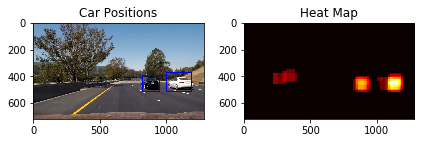

test_images/test5.jpg
288 648


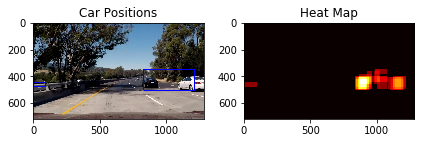

test_images/test4.jpg
288 648


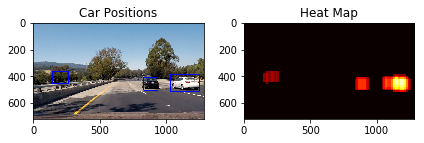

test_images/test2.jpg
288 648


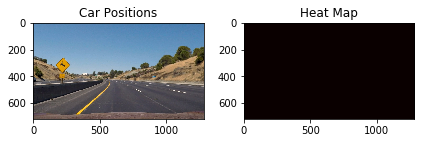

test_images/test1.jpg
288 648


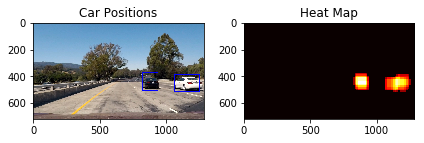

test_images/test3.jpg
288 648


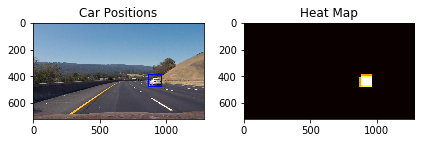

In [61]:
 
for image in glob.glob('test_images/*.jpg'):
    print(image)
    img = mpimg.imread(image)

    ystart = int(img.shape[0]*0.4)
    ystop = int(img.shape[0]*0.9)
    scale = 1.5

    print(ystart, ystop)

    out_img, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     plt.imshow(out_img)
#     plt.show()
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    mpimg.imsave('output_images/'+image.split('/')[-1], draw_img)
#     cv2.imwrite('output_images/'+image.split('/')[-1], draw_img)


    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    plt.show()



In [62]:
def process_image(img):
    ystart = int(img.shape[0]*0.4)
    ystop = int(img.shape[0]*0.9)
    scale = 1.5

    print(ystart, ystop)

    out_img, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     plt.imshow(out_img)
#     plt.show()
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4")#.subclip(0,3)

#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)

#NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

288 648
[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

288 648


  0%|          | 1/1261 [01:56<40:55:22, 116.92s/it]

288 648


  0%|          | 2/1261 [03:54<40:54:40, 116.98s/it]

288 648


  0%|          | 3/1261 [05:52<41:03:49, 117.51s/it]

288 648


  0%|          | 4/1261 [07:50<41:02:04, 117.52s/it]

288 648


  0%|          | 5/1261 [09:47<40:57:48, 117.41s/it]

288 648


  0%|          | 6/1261 [11:44<40:54:11, 117.33s/it]

288 648


  1%|          | 7/1261 [13:41<40:51:45, 117.31s/it]

288 648


  1%|          | 8/1261 [15:39<40:50:07, 117.32s/it]

288 648


  1%|          | 9/1261 [17:36<40:45:49, 117.21s/it]

288 648


  1%|          | 10/1261 [19:33<40:42:29, 117.15s/it]

288 648


  1%|          | 11/1261 [21:32<40:52:58, 117.74s/it]

288 648


  1%|          | 12/1261 [23:29<40:47:34, 117.58s/it]

288 648


  1%|          | 13/1261 [25:26<40:43:19, 117.47s/it]

288 648


  1%|          | 14/1261 [27:23<40:39:21, 117.37s/it]

288 648


  1%|          | 15/1261 [29:23<40:53:46, 118.16s/it]

288 648


  1%|▏         | 16/1261 [31:21<40:50:41, 118.11s/it]

288 648


  1%|▏         | 17/1261 [33:19<40:46:17, 117.99s/it]

288 648


  1%|▏         | 18/1261 [35:17<40:41:45, 117.86s/it]

288 648


  2%|▏         | 19/1261 [37:15<40:43:01, 118.02s/it]

288 648


  2%|▏         | 20/1261 [39:14<40:43:57, 118.16s/it]

288 648


  2%|▏         | 21/1261 [41:11<40:37:48, 117.96s/it]

288 648


  2%|▏         | 22/1261 [43:08<40:32:23, 117.79s/it]

288 648


  2%|▏         | 23/1261 [45:07<40:33:06, 117.92s/it]

288 648


  2%|▏         | 24/1261 [47:04<40:28:54, 117.81s/it]

288 648


  2%|▏         | 25/1261 [49:02<40:24:19, 117.69s/it]

288 648


  2%|▏         | 26/1261 [50:59<40:20:47, 117.61s/it]

288 648


  2%|▏         | 27/1261 [52:57<40:19:36, 117.65s/it]

288 648


  2%|▏         | 28/1261 [54:54<40:14:46, 117.51s/it]

288 648


  2%|▏         | 29/1261 [56:52<40:16:41, 117.70s/it]

288 648


  2%|▏         | 30/1261 [58:50<40:13:58, 117.66s/it]

288 648


  2%|▏         | 31/1261 [1:00:49<40:19:32, 118.03s/it]

288 648


  3%|▎         | 32/1261 [1:02:46<40:14:24, 117.87s/it]

288 648


  3%|▎         | 33/1261 [1:04:44<40:11:59, 117.85s/it]

288 648


  3%|▎         | 34/1261 [1:06:41<40:07:12, 117.71s/it]

288 648


  3%|▎         | 35/1261 [1:08:39<40:04:14, 117.66s/it]

288 648


  3%|▎         | 36/1261 [1:10:36<40:00:05, 117.56s/it]

288 648


  3%|▎         | 37/1261 [1:12:34<39:59:12, 117.61s/it]

288 648


  3%|▎         | 38/1261 [1:14:32<39:58:47, 117.68s/it]

288 648


  3%|▎         | 39/1261 [1:16:29<39:57:18, 117.71s/it]

288 648


  3%|▎         | 40/1261 [1:18:27<39:54:54, 117.69s/it]

288 648


  3%|▎         | 41/1261 [1:20:25<39:52:27, 117.66s/it]

288 648


  3%|▎         | 42/1261 [1:22:23<39:51:35, 117.72s/it]

288 648


  3%|▎         | 43/1261 [1:24:21<39:56:12, 118.04s/it]

288 648


  3%|▎         | 44/1261 [1:26:19<39:51:15, 117.89s/it]

288 648


  4%|▎         | 45/1261 [1:28:17<39:49:25, 117.90s/it]

288 648


  4%|▎         | 46/1261 [1:30:14<39:43:50, 117.72s/it]

288 648


  4%|▎         | 47/1261 [1:32:11<39:39:46, 117.62s/it]

288 648


  4%|▍         | 48/1261 [1:34:09<39:36:04, 117.53s/it]

288 648


  4%|▍         | 49/1261 [1:36:06<39:33:00, 117.48s/it]

288 648


  4%|▍         | 50/1261 [1:38:03<39:30:13, 117.43s/it]

288 648


  4%|▍         | 51/1261 [1:40:01<39:29:22, 117.49s/it]

288 648


  4%|▍         | 52/1261 [1:41:59<39:27:55, 117.52s/it]

288 648


  4%|▍         | 53/1261 [1:43:57<39:29:00, 117.67s/it]

288 648


  4%|▍         | 54/1261 [1:45:54<39:23:59, 117.51s/it]

288 648


  4%|▍         | 55/1261 [1:47:52<39:23:08, 117.57s/it]

288 648


  4%|▍         | 56/1261 [1:49:49<39:20:10, 117.52s/it]

288 648


  5%|▍         | 57/1261 [1:51:47<39:21:13, 117.67s/it]

288 648


  5%|▍         | 58/1261 [1:53:44<39:16:43, 117.54s/it]

288 648


  5%|▍         | 59/1261 [1:55:42<39:16:44, 117.64s/it]

288 648


  5%|▍         | 60/1261 [1:57:40<39:13:44, 117.59s/it]

288 648


  5%|▍         | 61/1261 [1:59:37<39:11:51, 117.59s/it]

288 648


  5%|▍         | 62/1261 [2:01:35<39:09:11, 117.56s/it]

288 648


  5%|▍         | 63/1261 [2:03:32<39:06:23, 117.52s/it]

288 648


  5%|▌         | 64/1261 [2:05:29<39:03:26, 117.47s/it]

288 648


  5%|▌         | 65/1261 [2:07:26<38:58:53, 117.34s/it]

288 648


  5%|▌         | 66/1261 [2:09:23<38:55:17, 117.25s/it]

288 648


  5%|▌         | 67/1261 [2:11:21<38:53:09, 117.24s/it]

288 648


  5%|▌         | 68/1261 [2:13:18<38:50:46, 117.22s/it]

288 648


  5%|▌         | 69/1261 [2:15:15<38:49:09, 117.24s/it]

288 648


  6%|▌         | 70/1261 [2:17:12<38:47:10, 117.24s/it]

288 648


  6%|▌         | 71/1261 [2:19:09<38:41:54, 117.07s/it]

288 648


  6%|▌         | 72/1261 [2:21:06<38:37:01, 116.92s/it]

288 648


  6%|▌         | 73/1261 [2:23:02<38:33:24, 116.84s/it]

288 648


  6%|▌         | 74/1261 [2:24:59<38:29:19, 116.73s/it]

288 648


  6%|▌         | 75/1261 [2:26:55<38:25:55, 116.66s/it]

288 648


  6%|▌         | 76/1261 [2:28:52<38:23:16, 116.62s/it]

288 648


  6%|▌         | 77/1261 [2:30:49<38:22:17, 116.67s/it]

288 648


  6%|▌         | 78/1261 [2:32:45<38:19:23, 116.62s/it]

288 648


  6%|▋         | 79/1261 [2:34:42<38:18:50, 116.69s/it]

288 648


  6%|▋         | 80/1261 [2:36:38<38:15:19, 116.61s/it]

288 648


  6%|▋         | 81/1261 [2:38:35<38:14:55, 116.69s/it]

288 648


  7%|▋         | 82/1261 [2:40:33<38:18:19, 116.96s/it]

288 648


  7%|▋         | 83/1261 [2:42:30<38:19:01, 117.10s/it]

288 648


  7%|▋         | 84/1261 [2:44:27<38:17:36, 117.13s/it]

288 648


  7%|▋         | 85/1261 [2:46:24<38:14:05, 117.05s/it]

288 648


  7%|▋         | 86/1261 [2:48:21<38:10:28, 116.96s/it]

288 648


  7%|▋         | 87/1261 [2:50:18<38:05:52, 116.83s/it]

288 648


  7%|▋         | 88/1261 [2:52:15<38:05:07, 116.89s/it]

288 648


  7%|▋         | 89/1261 [2:54:12<38:04:44, 116.97s/it]

288 648


  7%|▋         | 90/1261 [2:56:08<38:00:33, 116.85s/it]

288 648


  7%|▋         | 91/1261 [2:58:06<38:02:09, 117.03s/it]

288 648


  7%|▋         | 92/1261 [3:00:04<38:06:01, 117.33s/it]

288 648


  7%|▋         | 93/1261 [3:02:02<38:06:25, 117.45s/it]

288 648


  7%|▋         | 94/1261 [3:03:59<38:04:57, 117.48s/it]

288 648


  8%|▊         | 95/1261 [3:05:57<38:05:16, 117.60s/it]

288 648


  8%|▊         | 96/1261 [3:07:54<38:01:08, 117.48s/it]

288 648


  8%|▊         | 97/1261 [3:09:51<37:57:13, 117.38s/it]

288 648


  8%|▊         | 98/1261 [3:11:48<37:53:07, 117.27s/it]

288 648


  8%|▊         | 99/1261 [3:13:45<37:47:08, 117.06s/it]

288 648


  8%|▊         | 100/1261 [3:15:42<37:43:16, 116.97s/it]

288 648


  8%|▊         | 101/1261 [3:17:39<37:42:52, 117.05s/it]

288 648


  8%|▊         | 102/1261 [3:19:36<37:41:07, 117.06s/it]

288 648


  8%|▊         | 103/1261 [3:21:34<37:44:16, 117.32s/it]

288 648


  8%|▊         | 104/1261 [3:23:31<37:41:25, 117.27s/it]

288 648


  8%|▊         | 105/1261 [3:25:28<37:39:26, 117.27s/it]

288 648


  8%|▊         | 106/1261 [3:27:25<37:34:20, 117.11s/it]

288 648


  8%|▊         | 107/1261 [3:29:21<37:28:19, 116.90s/it]

288 648


  9%|▊         | 108/1261 [3:31:19<37:31:41, 117.17s/it]

288 648


  9%|▊         | 109/1261 [3:33:16<37:27:36, 117.06s/it]

288 648


  9%|▊         | 110/1261 [3:35:13<37:24:43, 117.01s/it]

288 648


  9%|▉         | 111/1261 [3:37:10<37:25:30, 117.16s/it]

288 648


  9%|▉         | 112/1261 [3:39:09<37:28:59, 117.44s/it]

288 648


  9%|▉         | 113/1261 [3:41:06<37:28:27, 117.51s/it]

288 648


  9%|▉         | 114/1261 [3:43:04<37:29:15, 117.66s/it]

288 648


  9%|▉         | 115/1261 [3:45:03<37:31:13, 117.87s/it]

288 648


  9%|▉         | 116/1261 [3:47:00<37:28:54, 117.85s/it]

288 648


  9%|▉         | 117/1261 [3:48:58<37:26:11, 117.81s/it]

288 648


  9%|▉         | 118/1261 [3:50:56<37:23:00, 117.74s/it]

288 648


  9%|▉         | 119/1261 [3:52:54<37:21:34, 117.77s/it]

288 648


 10%|▉         | 120/1261 [3:54:51<37:16:48, 117.62s/it]

288 648


 10%|▉         | 121/1261 [3:56:49<37:19:22, 117.86s/it]

288 648


 10%|▉         | 122/1261 [3:58:47<37:16:55, 117.84s/it]

288 648


 10%|▉         | 123/1261 [4:00:45<37:16:10, 117.90s/it]

288 648


 10%|▉         | 124/1261 [4:02:43<37:15:57, 117.99s/it]

288 648


 10%|▉         | 125/1261 [4:04:41<37:10:18, 117.80s/it]

288 648


 10%|▉         | 126/1261 [4:06:38<37:08:12, 117.79s/it]

288 648


 10%|█         | 127/1261 [4:08:36<37:04:57, 117.72s/it]

288 648


 10%|█         | 128/1261 [4:10:34<37:02:51, 117.72s/it]

288 648


 10%|█         | 129/1261 [4:12:31<36:59:13, 117.63s/it]

288 648


 10%|█         | 130/1261 [4:14:29<36:59:57, 117.77s/it]

288 648


 10%|█         | 131/1261 [4:16:27<36:58:18, 117.79s/it]

288 648


 10%|█         | 132/1261 [4:18:25<36:55:17, 117.73s/it]

288 648


 11%|█         | 133/1261 [4:20:22<36:51:21, 117.63s/it]

288 648


 11%|█         | 134/1261 [4:22:19<36:48:29, 117.58s/it]

288 648


 11%|█         | 135/1261 [4:24:17<36:47:41, 117.64s/it]

288 648


 11%|█         | 136/1261 [4:26:15<36:45:15, 117.61s/it]

288 648


 11%|█         | 137/1261 [4:28:12<36:42:11, 117.55s/it]

288 648


 11%|█         | 138/1261 [4:30:10<36:38:43, 117.47s/it]

288 648


 11%|█         | 139/1261 [4:32:07<36:36:44, 117.47s/it]

288 648


 11%|█         | 140/1261 [4:34:04<36:34:58, 117.48s/it]

288 648


 11%|█         | 141/1261 [4:36:02<36:32:46, 117.47s/it]

288 648


 11%|█▏        | 142/1261 [4:37:59<36:29:41, 117.41s/it]

288 648


 11%|█▏        | 143/1261 [4:39:56<36:26:18, 117.33s/it]

288 648


 11%|█▏        | 144/1261 [4:41:53<36:21:55, 117.20s/it]

288 648


 11%|█▏        | 145/1261 [4:43:50<36:17:32, 117.07s/it]

288 648


 12%|█▏        | 146/1261 [4:45:47<36:13:16, 116.95s/it]

288 648


 12%|█▏        | 147/1261 [4:47:44<36:10:39, 116.91s/it]

288 648


 12%|█▏        | 148/1261 [4:49:40<36:07:59, 116.87s/it]

288 648


 12%|█▏        | 149/1261 [4:51:37<36:06:46, 116.91s/it]

288 648


 12%|█▏        | 150/1261 [4:53:34<36:03:57, 116.87s/it]

288 648


 12%|█▏        | 151/1261 [4:55:31<36:02:08, 116.87s/it]

288 648


 12%|█▏        | 152/1261 [4:57:28<35:58:39, 116.79s/it]

288 648


 12%|█▏        | 153/1261 [4:59:24<35:56:02, 116.75s/it]

288 648


 12%|█▏        | 154/1261 [5:01:21<35:52:32, 116.67s/it]

288 648


 12%|█▏        | 155/1261 [5:03:18<35:51:35, 116.72s/it]

288 648


 12%|█▏        | 156/1261 [5:05:14<35:49:18, 116.70s/it]

288 648


 12%|█▏        | 157/1261 [5:07:11<35:46:58, 116.68s/it]

288 648


 13%|█▎        | 158/1261 [5:09:08<35:45:20, 116.70s/it]

288 648


 13%|█▎        | 159/1261 [5:11:04<35:42:11, 116.63s/it]

288 648


 13%|█▎        | 160/1261 [5:13:01<35:40:49, 116.67s/it]

288 648


 13%|█▎        | 161/1261 [5:14:58<35:40:00, 116.73s/it]

288 648


 13%|█▎        | 162/1261 [5:16:55<35:39:11, 116.79s/it]

288 648


 13%|█▎        | 163/1261 [5:18:52<35:38:04, 116.83s/it]

288 648


 13%|█▎        | 164/1261 [5:20:48<35:35:31, 116.80s/it]

288 648


 13%|█▎        | 165/1261 [5:22:45<35:32:52, 116.76s/it]

288 648


 13%|█▎        | 166/1261 [5:24:42<35:31:31, 116.80s/it]

288 648


 13%|█▎        | 167/1261 [5:26:39<35:30:45, 116.86s/it]

288 648


 13%|█▎        | 168/1261 [5:28:36<35:28:57, 116.87s/it]

288 648


 13%|█▎        | 169/1261 [5:30:33<35:30:42, 117.07s/it]

288 648


 13%|█▎        | 170/1261 [5:32:31<35:33:59, 117.36s/it]

288 648


 14%|█▎        | 171/1261 [5:34:28<35:29:49, 117.24s/it]

288 648


 14%|█▎        | 172/1261 [5:36:26<35:30:56, 117.41s/it]

288 648


 14%|█▎        | 173/1261 [5:38:24<35:29:50, 117.45s/it]

288 648


 14%|█▍        | 174/1261 [5:40:21<35:25:04, 117.30s/it]

288 648


 14%|█▍        | 175/1261 [5:42:18<35:22:25, 117.26s/it]

288 648


 14%|█▍        | 176/1261 [5:44:15<35:22:31, 117.37s/it]

288 648


 14%|█▍        | 177/1261 [5:46:13<35:23:10, 117.52s/it]

288 648


 14%|█▍        | 178/1261 [5:48:11<35:21:17, 117.52s/it]

288 648


 14%|█▍        | 179/1261 [5:50:08<35:17:02, 117.40s/it]

288 648


 14%|█▍        | 180/1261 [5:52:05<35:13:19, 117.30s/it]

288 648


 14%|█▍        | 181/1261 [5:54:02<35:12:09, 117.34s/it]

288 648


 14%|█▍        | 182/1261 [5:56:01<35:16:44, 117.71s/it]

288 648


 15%|█▍        | 183/1261 [5:57:58<35:11:29, 117.52s/it]

288 648


 15%|█▍        | 184/1261 [5:59:56<35:11:20, 117.62s/it]

288 648


 15%|█▍        | 185/1261 [6:01:53<35:08:38, 117.58s/it]

288 648


 15%|█▍        | 186/1261 [6:03:51<35:06:32, 117.57s/it]

288 648


 15%|█▍        | 187/1261 [6:05:48<35:03:33, 117.52s/it]

288 648


 15%|█▍        | 188/1261 [6:07:47<35:06:58, 117.82s/it]

288 648


 15%|█▍        | 189/1261 [6:09:44<35:00:01, 117.54s/it]

288 648


 15%|█▌        | 190/1261 [6:11:41<34:55:45, 117.41s/it]

288 648


 15%|█▌        | 191/1261 [6:13:38<34:52:55, 117.36s/it]

288 648


 15%|█▌        | 192/1261 [6:15:35<34:49:34, 117.28s/it]

288 648


 15%|█▌        | 193/1261 [6:17:32<34:47:02, 117.25s/it]

288 648


 15%|█▌        | 194/1261 [6:19:30<34:47:46, 117.40s/it]

288 648


 15%|█▌        | 195/1261 [6:21:29<34:55:40, 117.96s/it]

288 648


 16%|█▌        | 196/1261 [6:23:27<34:52:37, 117.89s/it]

288 648


 16%|█▌        | 197/1261 [6:25:25<34:50:24, 117.88s/it]

288 648


 16%|█▌        | 198/1261 [6:27:23<34:48:09, 117.86s/it]

288 648


 16%|█▌        | 199/1261 [6:29:20<34:44:27, 117.77s/it]

288 648


 16%|█▌        | 200/1261 [6:31:19<34:45:42, 117.95s/it]

288 648


 16%|█▌        | 201/1261 [6:33:16<34:43:05, 117.91s/it]

288 648


 16%|█▌        | 202/1261 [6:35:14<34:41:09, 117.91s/it]

288 648


 16%|█▌        | 203/1261 [6:37:15<34:55:01, 118.81s/it]

288 648
